In [1]:
import geopandas as gpd
import contextily as cx
from shapely.geometry import LineString

from data.geo import label_point_dispersion
from data.constants import (WEB_CRS)

In [2]:
bike_stations_file_in = "../data/raw/bike_stations.geojson"
bike_stations = gpd.read_file(bike_stations_file_in)

# Cardinality

In [3]:
print("We expect {} stations.".format(
    bike_stations.drop_duplicates(['station_id','vintage']).shape[0]
))

We expect 3656 stations.


# Relational

## ID to Names

In [4]:
assert all(bike_stations.groupby(['name'])['station_id'].nunique() == 1), "name to id worse than m:1"
print("id to name is worse than m:1? {}".format(
    all(bike_stations.groupby(['station_id'])['name'].nunique() == 1)
))
# Names always point to 1 id but ids can point to multiple names. Let's explore:

id to name is worse than m:1? False


<Axes: xlabel='name'>

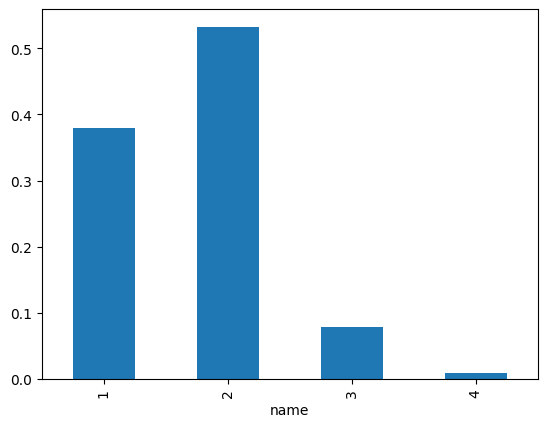

In [5]:
nnames = bike_stations.groupby(['station_id'])['name'].transform('nunique')
nnames.value_counts(normalize=True).sort_index().plot(kind='bar')

In [6]:

bike_stations[nnames == nnames.max()].sort_values(['station_id','name'])[['station_id','name','vintage']].drop_duplicates()
# So it looks like ids are not stable across vintages. 

,station_id,name,vintage
346,53.0,Green St & Randolph St,Divvy_Stations_Trips_2014_Q1Q2.zip
3120,53.0,LaSalle (Wells) St & Huron St,Divvy_Trips_2017_Q3Q4.zip
36,53.0,Wells St & Erie St,Divvy_Stations_Trips_2013.zip
635,53.0,Wells St & Erie St,Divvy_Stations_Trips_2014_Q3Q4.zip
948,53.0,Wells St & Erie St,Divvy_Trips_2015-Q1Q2.zip
1860,53.0,Wells St & Huron St,Divvy_Trips_2016_Q1Q2.zip
2452,53.0,Wells St & Huron St,Divvy_Trips_2016_Q3Q4.zip
3013,53.0,Wells St & Huron St,Divvy_Trips_2017_Q1Q2.zip
2493,80.0,Aberdeen St & Madison (Monroe) St,Divvy_Trips_2017_Q1Q2.zip
57,80.0,Aberdeen St & Madison St,Divvy_Stations_Trips_2013.zip


## Vintage to Names

In [7]:
assert all(bike_stations.groupby(['station_id','vintage'])['name'].nunique() == 1), "id to name worse than m:1"
predicate = lambda x: (~x.duplicated(subset=['station_id','vintage'])).all()
assert all(bike_stations.groupby('name').apply(predicate, include_groups=False)), "name to id worse than m:1"
# ID-Vintages are 1:1 with names

## Vintage to Points

In [8]:
assert all(bike_stations.groupby('geometry')['station_id'].nunique() == 1), "geom to id worse than m:1"
assert all(bike_stations.groupby(["station_id","vintage"])['geometry'].nunique() ==1), "id to geom worse than m:1"
# Vintages are 1:1 with points

## Names to Points

Maybe we can disperse with ids if the names are good enough?

In [9]:
print("name to geom at least m:1? {}".format(
    all(bike_stations.groupby(["name"])['geometry'].nunique() ==1)
))
print("geom to name at least m:1? {}".format(
    all(bike_stations.groupby('geometry')['name'].nunique() == 1)
))

name to geom at least m:1? False
geom to name at least m:1? False


In [10]:
bike_stations = bike_stations.pipe(label_point_dispersion, ['name'])

In [11]:
bike_stations[bike_stations['diam_mi'] > .125].sort_values(['station_id','name','vintage'])

,station_id,name,vintage,geometry,diam_ft,diam_mi
1420,2.0,Buckingham Fountain,Divvy_Trips_2016_Q1Q2.zip,POINT (-87.62397 41.87267),1295.229328,0.245316
2541,2.0,Buckingham Fountain,Divvy_Trips_2017_Q1Q2.zip,POINT (-87.61949 41.88106),1295.229328,0.245316
3071,2.0,Buckingham Fountain,Divvy_Trips_2017_Q3Q4.zip,POINT (-87.62033 41.87639),1295.229328,0.245316


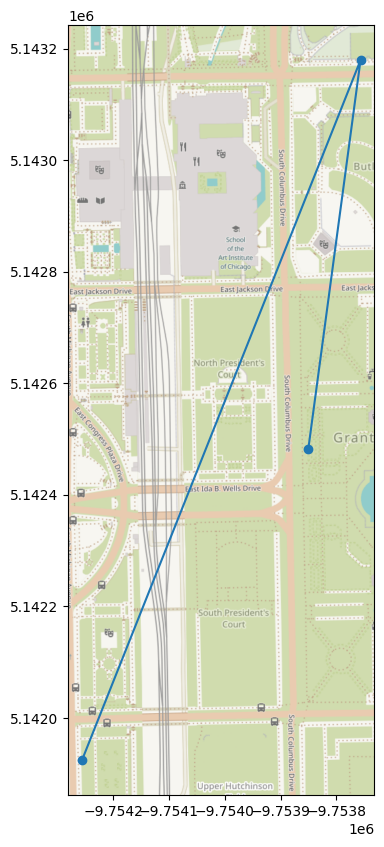

In [12]:
# Visualize where these points are
point_plot_data = bike_stations[(bike_stations['name']=="Buckingham Fountain")].to_crs(WEB_CRS)
line_plot_data = gpd.GeoSeries([point_plot_data.geometry.agg(LineString)], crs=WEB_CRS)
ax = point_plot_data.plot(figsize=(10, 10))
line_plot_data.plot(ax=ax)
cx.add_basemap(ax, attribution=False)
# 2/3 of these points aren't near the fountain so let's not use the names!

## IDs to Points

In [13]:
bike_stations = bike_stations.pipe(label_point_dispersion, ['station_id'])

In [14]:
suspicious = bike_stations['diam_mi'] == bike_stations['diam_mi'].max()
bike_stations[suspicious].sort_values(['station_id'])[['station_id','name','vintage']]
# Well we should have seen this coming, since we already know ID -> Name is bad
# and Name -> Point is bad. So transitively, ID -> Point is also bad.

,station_id,name,vintage
578,392.0,Clark St & Winnemac Ave,Divvy_Stations_Trips_2014_Q1Q2.zip
1257,392.0,Perry Ave & 69th St,Divvy_Trips_2015-Q1Q2.zip
1737,392.0,Perry Ave & 69th St,Divvy_Trips_2016_Q1Q2.zip
2315,392.0,Perry Ave & 69th St,Divvy_Trips_2016_Q3Q4.zip
2878,392.0,Perry Ave & 69th St,Divvy_Trips_2017_Q1Q2.zip
3428,392.0,Perry Ave & 69th St,Divvy_Trips_2017_Q3Q4.zip


# TL/DR

station_id, vintage is the composite primary key.
name is generally descriptively helpful, but not 100% consistent.